In [3]:
from src.debate_manager import DebateManager
import logging
import os
from openai import OpenAI

# Set up OpenAI client
api_key = os.environ["OPENAI_API_KEY"]
client = OpenAI(api_key=api_key)

In [4]:
# Create PyDantic classes to represent the DebateGraph
from pydantic import BaseModel, Field
from typing import List, Optional, Dict
from datetime import datetime

class ArgumentEntity(BaseModel):
    id: int
    type: str = "argument"
    content: str

class Relationship(BaseModel):
    source_id: int
    target_id: int
    relationship_type: str = Field(..., description="Relationship types: [claim, premise, conclusion, first principle, rebuttal]")

class DebateGraph(BaseModel):
    entities: List[ArgumentEntity]
    relationships: List[Relationship]

In [5]:
# Create example debate graph for prompting
main_claim = ArgumentEntity(
    id=1,
    content="Climate change poses a serious threat to global ecosystems and human society"
)

supporting_premise1 = ArgumentEntity(
    id=2,
    content="Global temperatures have risen by approximately 1°C since pre-industrial times"
)

supporting_premise2 = ArgumentEntity(
    id=3,
    content="Rising temperatures are primarily caused by human greenhouse gas emissions"
)

conclusion = ArgumentEntity(
    id=4,
    content="Immediate action is required to reduce greenhouse gas emissions"
)

rebuttal = ArgumentEntity(
    id=5,
    content="Natural climate cycles have caused temperature variations throughout Earth's history"
)

first_principle = ArgumentEntity(
    id=6,
    content="Scientific measurements and data provide reliable evidence for understanding climate patterns"
)

# Create relationships between arguments
relationships = [
    Relationship(
        source_id=supporting_premise1.id,
        target_id=main_claim.id,
        relationship_type="premise"
    ),
    Relationship(
        source_id=supporting_premise2.id,
        target_id=main_claim.id,
        relationship_type="premise"
    ),
    Relationship(
        source_id=main_claim.id,
        target_id=conclusion.id,
        relationship_type="claim"
    ),
    Relationship(
        source_id=rebuttal.id,
        target_id=supporting_premise2.id,
        relationship_type="rebuttal"
    ),
    Relationship(
        source_id=first_principle.id,
        target_id=supporting_premise1.id,
        relationship_type="first principle"
    )
]

# Create the debate graph
debate_graph = DebateGraph(
    entities=[main_claim, supporting_premise1, supporting_premise2, conclusion, rebuttal, first_principle],
    relationships=relationships
)

# Print the JSON representation
example_graph = debate_graph.model_dump_json(indent=2)

In [45]:
# Helper functions
import json

def extract_scene_graph(response):
    start_marker = "<SCENE_GRAPH>"
    end_marker = "</SCENE_GRAPH>"
    
    start_index = response.find(start_marker) + len(start_marker)
    end_index = response.find(end_marker)
    
    scene_graph_json = response[start_index:end_index].strip()
    return DebateGraph.model_validate_json(scene_graph_json)

def extract_thoughts_and_winner(judge_response):
    # Extract thoughts
    thoughts_start = judge_response.find("<thoughts>") + len("<thoughts>")
    thoughts_end = judge_response.find("</thoughts>")
    thoughts = judge_response[thoughts_start:thoughts_end].strip()

    # Extract winner
    winner_start = judge_response.find("<winner>") + len("<winner>")
    winner_end = judge_response.find("</winner>")
    winner = judge_response[winner_start:winner_end].strip()

    return thoughts, winner

def display_scene_graph(scene_graph):
    print(json.dumps(scene_graph, indent=4))

def generate(prompt):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

import math

def calculate_rmse(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Lists must have the same length")

    mse = sum((a - b) ** 2 for a, b in zip(list1, list2)) / len(list1)
    rmse = math.sqrt(mse)
    return rmse

# Used two combine the graphs into one
def combine_debate_graphs(graph1: DebateGraph, graph2: DebateGraph) -> DebateGraph:
    """
    Combines two DebateGraph objects into a single DebateGraph.
    
    Args:
        graph1 (DebateGraph): First debate graph
        graph2 (DebateGraph): Second debate graph
        
    Returns:
        DebateGraph: A new debate graph containing all entities and relationships from both graphs
    """
    # Create sets of entity IDs to check for duplicates
    existing_entity_ids = {entity.id for entity in graph1.entities}
    
    # Combine entities, avoiding duplicates based on ID
    combined_entities = list(graph1.entities)
    for entity in graph2.entities:
        if entity.id not in existing_entity_ids:
            combined_entities.append(entity)
            existing_entity_ids.add(entity.id)
    
    # Combine relationships
    combined_relationships = list(graph1.relationships)
    for rel in graph2.relationships:
        # Only add relationship if both source and target entities exist in combined entities
        if any(e.id == rel.source_id for e in combined_entities) and \
            any(e.id == rel.target_id for e in combined_entities):
            combined_relationships.append(rel)
    
    # Create new DebateGraph with combined entities and relationships
    return DebateGraph(
        entities=combined_entities,
        relationships=combined_relationships
    )

import networkx as nx
import matplotlib.pyplot as plt

def graph_scene_graph(debate_graph):
    G = nx.DiGraph()  # Use a directed graph to represent relationships

    # Add nodes with attributes
    for entity in debate_graph.entities:
        G.add_node(entity.id, content=entity.content)

    # Add edges with relationship types
    for rel in debate_graph.relationships:
        G.add_edge(rel.source_id, rel.target_id, relationship=rel.relationship_type)

    # Set up the plot
    plt.figure(figsize=(15, 10))
    
    # Create the layout
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    # Draw the graph
    nx.draw(G, pos, with_labels=False, node_color='lightblue', 
            node_size=3000, arrowsize=20)

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'relationship')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # Draw node labels with content
    node_labels = {node: f"ID: {node}\n{data['content'][:50]}..." 
                  for node, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

    plt.title("Debate Graph Visualization")
    plt.axis('off')
    
    return plt

# Function to graph all scene graphs in the history list
def graph_all_scene_graphs(pro_scene_graph_history, con_scene_graph_history):
    for i, (pro_scene_graph, con_scene_graph) in enumerate(zip(pro_scene_graph_history, con_scene_graph_history)):
        print(f"Pro Scene Graph {i+1}:")
        graph_scene_graph(pro_scene_graph)
        print(f"Con Scene Graph {i+1}:")
        graph_scene_graph(con_scene_graph)

def save_results(winners, structs, batch_number):
    with open(f'debate_results_batch_{batch_number}.json', 'w') as f:
        json.dump(winners, f, indent=4)
    with open(f'structs_batch_{batch_number}.json', 'w') as f:
        json.dump(structs, f, indent=4)



In [50]:
# Prompt Functions
def create_scene_graph_prompt(topic, side, speech):
    base_prompt = f"""
    You are an AI agent tasked with analyzing a debate. The topic of the debate is: "{topic}". 
    You are representing the {side} side. Below is a speech from your side:

    "{speech}"

    Based on this speech without making up new arguments, generate a scene graph in JSON format that includes the following:
    1. Arguments, and relationships that are most relevant to understanding your side's speech and point of view.
    2. Ensure the relations used are one of the following: ["claim", "premise", "conclusion", "first principle", "rebuttal"]
    3. The scene graph should be structured to clearly represent the key points and relationships in the argument.
    4. All ids should be unique

    Here is an example scene graph for climate change, you should follow this format in your generated scene graph:

    "{example_graph}"

    Please provide the scene graph between the markers <SCENE_GRAPH> and </SCENE_GRAPH>
    """

    return base_prompt

def create_counterfactual_scene_graph_prompt(topic, con_speech, pro_scene_graph):
    base_prompt = f"""
    You are an AI agent representing the con side in a debate. The topic of the debate is: "{topic}". 
    Below is a speech from your side:

    "{con_speech}"

    Additionally, here is the current scene graph representing the debate which has just been modified by the pro side:

    {json.dumps(pro_scene_graph, indent=2)}

    Your task is to generate counterfactual argument entities and relationships in the same JSON format that refutes the pro side's arguments and introduces new arguments for the con side. All of your arguments should be based on the given con side speech, do not make up new arguments that are not mentioned in the con side speech. The counterfactual scene graph should include the following:
    1. Arguments, and relationships that directly counter the pro side's scene graph.
    2. Arguments, and relationships that support the con side's arguments.
    3. The scene graph should be structured to clearly represent the key points and relationships in the argument.
    4. Make reference to the pro side's arguments by referencing their ids in the your proposed relations.
    5. Do not include duplicates of the pro side's arguments in your graph when you could instead reference their ids in your relations.
    6. Do not add any new fields to the json which are not in the provided examples.
    7. Source and Target Id should always refer to an integer of an existing argument.
    8. All generated argument ids should be unique from any other id in the current scene graph.
    9. Ensure the relations used are one of the following: ["claim", "premise", "conclusion", "first principle", "rebuttal"]

    Your proposed arguments and relationships will be added to the scene graph to form an update debate graph from which a judge can determine the winner.

    Here is an example another example scene graph for climate change which you can use as reference for the format of your json output:

    "{example_graph}"

    Please provide the counterfactual scene graph between the markers <SCENE_GRAPH> and </SCENE_GRAPH>.

    You should additionally provide a brief explanation of the counterfactual scene graph between the markers <EXPLANATION> and </EXPLANATION>.
    """

    return base_prompt

def create_pro_counterfactual_scene_graph_prompt(topic, pro_speech, con_scene_graph):
    base_prompt = f"""
    You are an AI agent representing the pro side in a debate. The topic of the debate is: "{topic}". 
    Below is a speech from your side:

    "{pro_speech}"

    Additionally, here is the current scene graph representing the debate which has just been modified by the con side:

    {json.dumps(con_scene_graph, indent=2)}

    Your task is to generate counterfactual argument entities and relationships in the same JSON format that refutes the con side's arguments and introduces new arguments for the pro side. All of your arguments should be based on the given pro side speech, do not make up new arguments that are not mentioned in the pro side speech. The counterfactual scene graph should include the following:
    1. Arguments, and relationships that directly counter the con side's scene graph.
    2. Arguments, and relationships that support the pro side's arguments.
    3. The scene graph should be structured to clearly represent the key points and relationships in the argument.
    4. Make reference to the con side's arguments by referencing their ids in the your proposed relations.
    5. Do not include duplicates of the con side's arguments in your graph when you could instead reference their ids in your relations.
    6. Do not add any new fields to the json which are not in the provided examples.
    7. Source and Target Id should always refer to an integer of an existing argument.
    8. All generated argument ids should be unique from any other id in the current scene graph.
    9. Ensure the relations used are one of the following: ["claim", "premise", "conclusion", "first principle", "rebuttal"]

    Your proposed arguments and relationships will be added to the scene graph to form an update debate graph from which a judge can determine the winner.

    Here is an example another example scene graph for climate change which you can use as reference for the format of your json output:

    "{example_graph}"

    Please provide the counterfactual scene graph between the markers <SCENE_GRAPH> and </SCENE_GRAPH>.

    You should additionally provide a brief explanation of the counterfactual scene graph between the markers <EXPLANATION> and </EXPLANATION>.
    """

    return base_prompt

def create_judge_prompt(topic, scene_graph, thoughts_history):
    base_prompt = f"""
    You are an AI judge tasked with evaluating the logical validity of arguments in a debate. The topic of the debate is: "{topic}". 
    Below is the scene graph generated by the pro and con sides:

    Scene Graph:
    {json.dumps(scene_graph, indent=4)}

    Additionally, here is the history of your previous thoughts:
    {thoughts_history}

    Your task is to analyze the logical structure and validity of each side's arguments based on the scene graph. Consider the relationships and attributes in the graph to determine the strength and coherence of the arguments. Provide your reasoning and conclusion wrapped in <thoughts> tags. Based on this analysis and the history of your previous thoughts, decide which side has presented a stronger argument. If the pro side has a stronger argument, write <winner>pro</winner>. If the con side has a stronger argument, write <winner>con</winner>. If both sides are equally strong, write <winner>tie</winner>.

    Please provide your reasoning and conclusion between the markers <thoughts> and </thoughts>, and your decision between the markers <winner> and </winner>.
    """

    return base_prompt

In [46]:
# Debate Logic
def process_debate(debate):
    topic = debate['motion']['motion']
    pro_speeches = [speech['content'] for speech in debate['speech'] if speech['debater_name'] == debate['motion']['pro_side'][0]['name']]
    con_speeches = [speech['content'] for speech in debate['speech'] if speech['debater_name'] == debate['motion']['con_side'][0]['name']]

    pro_scene_graph = {}
    con_scene_graph = {}
    graph_history = []
    thought_history = ""
    winners = []

    # Iterate over speeches
    for i, (pro_speech, con_speech) in enumerate(zip(pro_speeches, con_speeches)):
        # Generate pro side counterfactual prompt
        if i == 0:
            pro_prompt = create_scene_graph_prompt(topic, 'pro', pro_speech)
            result = None
            while result is None:
                try:
                    pro_response = generate(pro_prompt)
                    result = extract_scene_graph(pro_response)
                except Exception as e:
                    pass
            scene_graph = result
        else:
            pro_prompt = create_pro_counterfactual_scene_graph_prompt(topic, pro_speech, scene_graph.model_dump())
            result = None
            while result is None:
                try:
                    pro_response = generate(pro_prompt)
                    pro_scene_graph = extract_scene_graph(pro_response)
                    result = combine_debate_graphs(pro_scene_graph,scene_graph)
                except Exception as e:
                    pass
            scene_graph = result

        graph_history.append(scene_graph)

        # Generate con side counterfactual prompt
        con_prompt = create_counterfactual_scene_graph_prompt(topic, con_speech, scene_graph.model_dump())
        result = None
        while result is None:
            try:
                con_response = generate(con_prompt)
                con_scene_graph = extract_scene_graph(con_response)
                result = combine_debate_graphs(con_scene_graph,scene_graph)
            except Exception as e:
                pass
        scene_graph = result

        # Save con scene graph to history
        graph_history.append(scene_graph)

        # Generate judge prompt
        judge_prompt = create_judge_prompt(topic, scene_graph.model_dump(), thought_history)
        judge_response = generate(judge_prompt)
        thoughts, winner = extract_thoughts_and_winner(judge_response)
        thought_history += f"Thought for round {i+1}: {thoughts}\n"
        winners.append(winner)

        struct = {
            "graph_history": graph_history,
            "thoughts": thoughts,
            "winner": winners
        }

    return winner, struct

In [9]:
# Loading DebateArt
import pandas as pd

# Load the CSV file
file_path = 'data/panel_bench/DebateArt/gold/dimension.csv'
df = pd.read_csv(file_path)

# Extract the dart_id column and format it
dart_ids = list(dict.fromkeys(df['dart_id'].apply(lambda x: f"{x:04d}").tolist()))

# Loading Manager
manager = DebateManager("config/data_config.yaml", debate_format="debateart")

# Print the formatted dart_ids
print(dart_ids)
print(len(dart_ids))

Loaded Config: {'datasets': {'bp_competition': {'data_dir': 'data/panel_bench/BP-Competition', 'formats': {'motion': 'motion/bp_{id}.yml', 'speech': 'speech/bp_{id}.yml'}}, 'debateart': {'data_dir': 'data/panel_bench/DebateArt', 'formats': {'motion': 'motion/debateart_{id}.yml', 'speech': 'speech/debateart_{id}.yml'}}}}
['0017', '0020', '0130', '0204', '0244', '0290', '0309', '0386', '0466', '0495', '0537', '0566', '0569', '0570', '0578', '0600', '0601', '0616', '0654', '0678', '0679', '0684', '0716', '0731', '0734', '0737', '0750', '0752', '0756', '0769', '0777', '0778', '0796', '0802', '0840', '0866', '0892', '0905', '0931', '0943', '0951', '0956', '0959', '0962', '0987', '0994', '1033', '1043', '1079', '1080', '3638', '3645', '3687', '3696', '3817', '3842', '3867', '3919', '3935', '3943', '3965', '3986', '4005', '4024', '4038', '4066', '4085', '4123', '4286', '4287', '4367', '4374', '4389', '4395', '4398', '4423', '4509', '4562', '4567', '4573', '4617', '4620', '4638', '4640', '4642

In [48]:
# Testing First Five
winners = []
structs = []

for dart_id in dart_ids[:1]:
    debate = manager.load_debate(dart_id)
    winner, struct = process_debate(debate)
    winners.append(winner)
    structs.append(struct)

print(winners)

['con']


<module 'matplotlib.pyplot' from 'c:\\Users\\12700K\\miniconda3\\envs\\debate\\Lib\\site-packages\\matplotlib\\pyplot.py'>

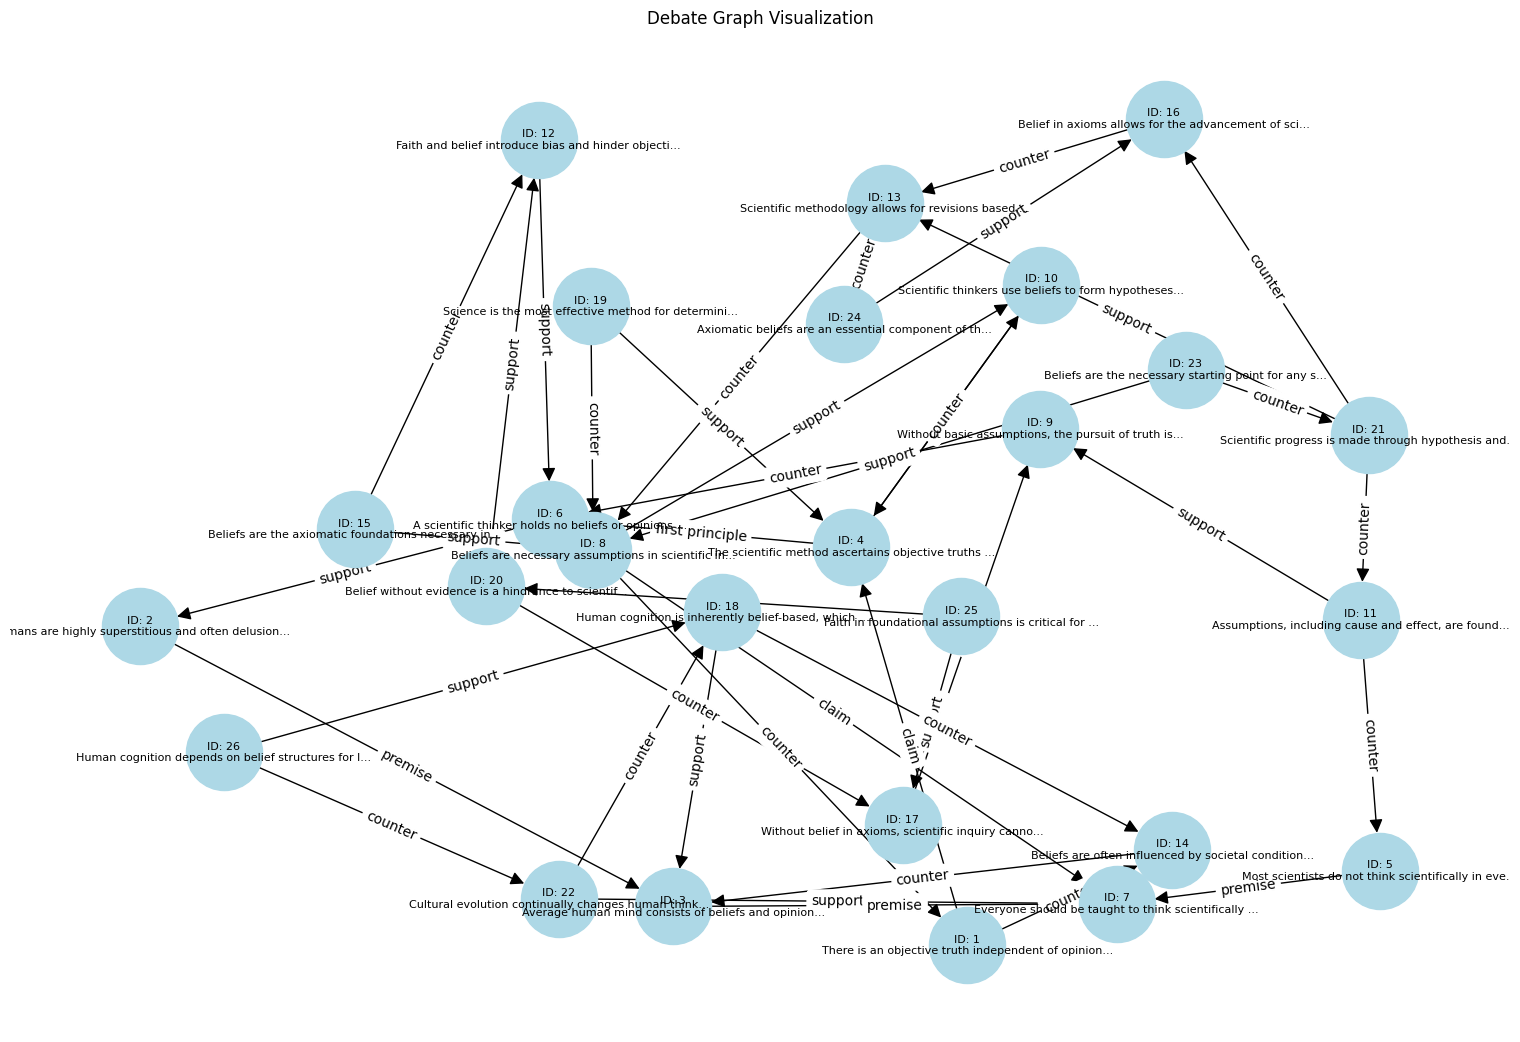

In [49]:
graph_scene_graph(structs[0]['graph_history'][-1])

In [ ]:
# Running on DebateArt
winners = {}
structs = {}
batch_number = 0
for i, dart_id in enumerate(dart_ids):
    try:
        debate = manager.load_debate(dart_id)
        winner, struct = process_debate(debate)
        winners[dart_id] = winner
        structs[dart_id] = struct
        print(f"Processed debate ID {dart_id}")
        print(f"i: {i}")
        print(f"Winner: {winner}")

        if (i + 1) % 10 == 0:
            batch_number += 1
            save_results(winners, structs, batch_number)
    except Exception as e:
        print(f"Error processing debate ID {dart_id}: {e}")
        continue

print(winners)

In [ ]:
# Benchmarking
ground_truth = {}
for dart_id in winners.keys():
    ground_truth[dart_id] = df.loc[(df['dart_id'] == int(dart_id)) & (df['dimension'] == 'argument')]['label'].values[0]

winners_float = {}
for dart_id in winners.keys():
    if winners[dart_id] == "pro":
        winners_float[dart_id] = 0.0
    elif winners[dart_id] == "con":
        winners_float[dart_id] = 1.0
    else:
        winners_float[dart_id] = 0.5
winners_float

gt = list(ground_truth.values())
wf = list(winners_float.values())
calculate_rmse(gt, wf)